In [159]:
# load the saved parameters and do visualization for W, a and C_alpha.
import numpy as np
import matplotlib.pyplot as plt
import pickle

w_plus = 3.0

path = f'/data3/wangshaobo/ICL/RPE/results_paper/NGram/C_W_a_parent2_n10000_L100_S3_H3_1.0_100.0_10.0_optsgd_w+{w_plus}_w-0.1_D3_c_alpha_init0.01_a_init0.01_alpha0.1_n-epochs[500, 500, 500].npz'
data = np.load(path)

# extract info from path, about L, S, H
path = path.split('/')[-1]
path = path.split('_')
L = int(path[5][1:])
S = int(path[6][1:])
H = int(path[7][1:])
D = path[14][1:]
print('L, S, H, D', L, S, H, D)



L, S, H, D 100 3 3 3


In [160]:
# check the dict of data saved with npz
print(data.files)
alphas = data['alphas']

['C_list', 'train_loss_list_1', 'val_loss_list_1', 'alphas', 'W_before', 'train_loss_list_2', 'val_loss_list_2', 'W_after', 'a_list', 'train_loss_list_3', 'val_loss_list_3']


(501, 8)


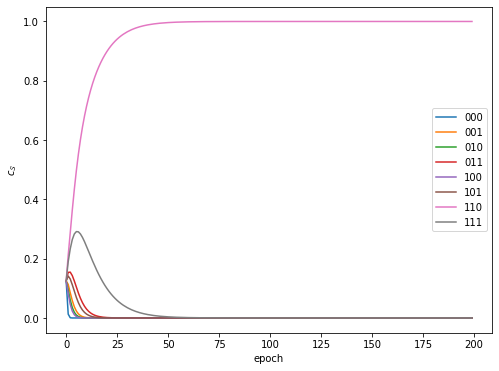

In [161]:
# plot C_list curve, C_list is a list of multiple C_alpha, draw the curve of each alpha.
# each alpha is corrensding to a binary coding of H+1 positions, change alpha to binary, then to a list of 0 and 1.
C_list = data['C_list']
# plot the ratio of each C_alpha **2 over the some of all C_alpha**2
C_list = C_list**2
C_list = C_list / np.sum(C_list, axis = 1)[:,np.newaxis]
print(C_list.shape)
keep = 200
plt.figure(figsize=(8,6))
for i in range(len(alphas)):
    plt.plot(C_list[:keep,i], label = alphas[i][1:])
    plt.legend()
plt.xlabel('epoch')
plt.ylabel(r'$c_\mathcal{S}$')
plt.show()

Text(0.5, 1.0, 'W_after')

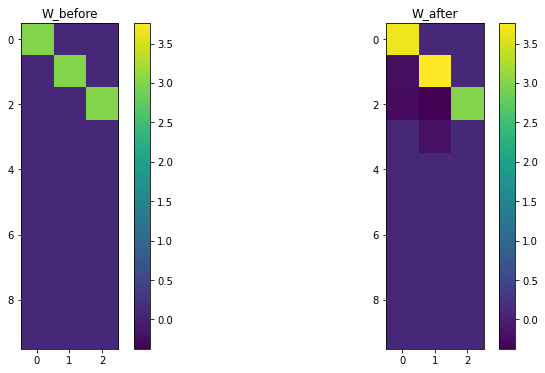

In [162]:
# draw W_before and W_after heatmap
W_before = data['W_before'][0][:10,:10]
W_after = data['W_after'][0][:10,:10]
# Get the min and max values for normalization
vmin = min(W_before.min(), W_after.min())
vmax = max(W_before.max(), W_after.max())

# Create the figure and subplots
plt.figure(figsize=(12, 6))

# Plot W_before
plt.subplot(1, 2, 1)
plt.imshow(W_before, aspect='equal', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('W_before')

# Plot W_after
plt.subplot(1, 2, 2)
plt.imshow(W_after, aspect='equal', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('W_after')



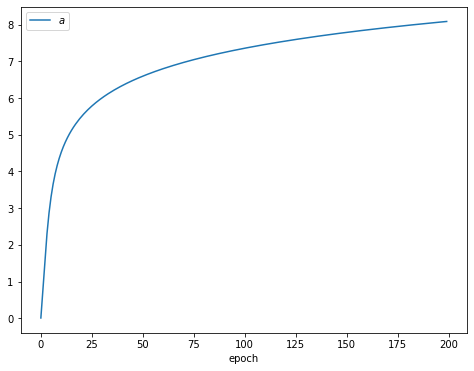

In [163]:
# plot a_list curve
a_list = data['a_list']
keep = 200
plt.figure(figsize=(8,6))
plt.plot(a_list[:keep],label=r'$a$')
plt.legend()
plt.xlabel('epoch')
plt.show()